In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nitime

In [2]:
ts1 = np.loadtxt("ts1.txt")
ts2 = np.loadtxt("ts2.txt")
ts3 = np.loadtxt("ts3.txt")

In [3]:
import numpy as np
from Operations.CO_FirstCrossing import CO_FirstCrossing

def CO_glscf(y, alpha, beta, tau = 'tau'):
    """
    """
    # Set tau to first zero-crossing of the autocorrelation function with the input 'tau'
    if tau == 'tau':
        tau = CO_FirstCrossing(y, 'ac', 0, 'discrete')
    
    # Take magnitudes of time-delayed versions of the time series
    y1 = np.abs(y[:-tau])
    y2 = np.abs(y[tau:])


    p1 = np.mean(np.multiply((y1 ** alpha), (y2 ** beta)))
    p2 = np.multiply(np.mean(y1 ** alpha), np.mean(y2 ** beta))
    p3 = np.sqrt(np.mean(y1 ** (2*alpha)) - (np.mean(y1 ** alpha))**2)
    p4 = np.sqrt(np.mean(y2 ** (2*beta)) - (np.mean(y2 ** beta))**2)

    glscf = (p1 - p2) / (p3 * p4)

    return glscf    


In [11]:
CO_glscf(ts1, 0.9, 0.4, 3)

0.25284356429315435

In [13]:
import numpy as np
from Operations.CO_FirstCrossing import CO_FirstCrossing
from Operations.CO_glscf import CO_glscf

def CO_fzcglscf(y, alpha, beta, maxtau = None):
    """
    """
    N = len(y) # the length of the time series

    if maxtau is None:
        maxtau = N
    
    glscfs = np.zeros(maxtau)

    for i in range(1, maxtau+1):
        tau = i

        glscfs[i-1] = CO_glscf(y, alpha, beta, tau)
        if (i > 1) and (glscfs[i-1]*glscfs[i-2] < 0):
            # Draw a straight line between these two and look at where it hits zero
            out = i - 1 + glscfs[i-1]/(glscfs[i-1]-glscfs[i-2])
            return out
    
    return maxtau # if the function hasn't exited yet, set output to maxtau 


In [86]:
import warnings
import numpy as np

def DN_cv(x, k = 1):
    """
    Coefficient of variation

    Coefficient of variation of order k is sigma^k / mu^k (for sigma, standard
    deviation and mu, mean) of a data vector, x

    Parameters:
    ----------
    x (array-like): The input data vector
    k (int, optional): The order of coefficient of variation (k = 1 is default)

    Returns:
    -------
    float: The coefficient of variation of order k
    """
    if not isinstance(k, int) or k < 0:
        warnings.warn('k should probably be a positive integer')
        # Carry on with just this warning, though
    
    # Compute the coefficient of variation (of order k) of the data
    return (np.std(x, ddof=1) ** k) / (np.mean(x) ** k)


In [88]:
DN_cv(ts3)

26.269342687595913

In [113]:
DN_nlogL_norm(ts2)

1.2765413621752804

In [118]:
import numpy as np 

def DN_HighLowMu(y):
    """
    The highlowmu statistic.

    The highlowmu statistic is the ratio of the mean of the data that is above the
    (global) mean compared to the mean of the data that is below the global mean.

    Paramters:
    ----------
    y (array-like): The input data vector

    Returns:
    --------
    float: The highlowmu statistic.
    """
    mu = np.mean(y) # mean of data
    mhi = np.mean(y[y > mu]) # mean of data above the mean
    mlo = np.mean(y[y < mu]) # mean of data below the mean
    out = np.divide((mhi-mu), (mu-mlo)) # ratio of the differences

    return out


In [119]:
DN_HighLowMu(ts2)

1.0325203252032518

In [120]:
import numpy as np

def BF_SimpleBinner(xData, numBins):
    """
    Generate a histogram from equally spaced bins.
   
    Parameters:
    xData (array-like): A data vector.
    numBins (int): The number of bins.

    Returns:
    tuple: (N, binEdges)
        N (numpy.ndarray): The counts
        binEdges (numpy.ndarray): The extremities of the bins.
    """
    minX = np.min(xData)
    maxX = np.max(xData)
    
    # Linearly spaced bins:
    binEdges = np.linspace(minX, maxX, numBins + 1)
    N = np.zeros(numBins, dtype=int)
    
    for i in range(numBins):
        if i < numBins - 1:
            N[i] = np.sum((xData >= binEdges[i]) & (xData < binEdges[i+1]))
        else:
            # the final bin
            N[i] = np.sum((xData >= binEdges[i]) & (xData <= binEdges[i+1]))
    
    return N, binEdges


In [140]:
from scipy import stats

def DN_Cumulants(y, cumWhatMay = 'skew1'):
    
    """
    """

    if cumWhatMay == 'skew1':
        out = stats.skew(y)
    elif cumWhatMay == 'skew2':
        out = stats.skew(y, bias=False)
    elif cumWhatMay == 'kurt1':
        out = stats.kurtosis(y, fisher=False)
    elif cumWhatMay == 'kurt2':
        out = stats.kurtosis(y, bias=False, fisher=False)
    else:
        raise ValueError('Requested Unknown cumulant must be: skew1, skew2, kurt1, or kurt2')
    
    return out


In [141]:
DN_Cumulants(ts1, cumWhatMay='kurt1')

1.497362974297833

In [142]:
DN_Cumulants(ts1, cumWhatMay='kurt2')

1.4958467355321061

In [144]:
import numpy as np

def EN_ApEN(y, mnom = 1, rth = 0.2):
    """
    """
    r = rth * np.std(y, ddof=1) # threshold of similarity
    N = len(y) # time series length
    phi = np.zeros(2) # phi[0] = phi_m, phi[1] = phi_{m+1}

    for k in range(2):
        m = mnom+k # pattern length
        C = np.zeros(N - m + 1)
        # define the matrix x, containing subsequences of u
        x = np.zeros((N-m+1, m))

        # Form vector sequences x from the time series y
        x = np.array([y[i:i+m] for i in range(N - m + 1)])
        
        for i in range(N - m + 1):
            # Calculate the number of x[j] within r of x[i]
            d = np.abs(x - x[i])
            if m > 1:
                d = np.max(d, axis=1)
            C[i] = np.sum(d <= r) / (N - m + 1)

        phi[k] = np.mean(np.log(C))

    return phi[0] - phi[1]


In [149]:
EN_ApEN(ts3, 2, 0.4)

1.514020217676181

In [152]:
import matplotlib.mlab
import numpy as np
import scipy
from scipy import signal
import math
import matplotlib

def MD_hrv_classic(y):
    """
    """

    # Standard defaults
    y = np.array(y)
    diffy = np.diff(y)
    N = len(y)

    # ------------------------------------------------------------------------------
    # Calculate pNNx percentage
    # ------------------------------------------------------------------------------
    # pNNx: recommendation as per Mietus et. al. 2002, "The pNNx files: ...", Heart
    # strange to do this for a z-scored time series...
    Dy = np.abs(diffy)
    PNNxfn = lambda x : np.mean(Dy > x/1000)

    out = {}

    out['pnn5'] = PNNxfn(5) # 0.0055*sigma
    out['pnn10'] = PNNxfn(10) # 0.01*sigma
    out['pnn20'] = PNNxfn(20) # 0.02*sigma
    out['pnn30'] = PNNxfn(30) # 0.03*sigma
    out['pnn40'] = PNNxfn(40) # 0.04*sigma

    # ------------------------------------------------------------------------------
    # Calculate PSD
    # ------------------------------------------------------------------------------

    F, Pxx = signal.periodogram(y, window=np.hanning(N))

    # Calculate spectral measures such as subband spectral power percentage, LF/HF ratio etc.
    LF_lo = 0.04 # /pi -- fraction of total power (max F is pi)
    LF_hi = 0.15
    HF_lo = 0.15
    HF_hi = 0.4

    fbinsize = F[1] - F[0]

    # Calculate PSD
    f, Pxx = signal.periodogram(y, window='hann', detrend=False)
    f *= 2 * np.pi
    #print(Pxx)

    # Calculate spectral measures
    LF_lo, LF_hi = 0.04, 0.15
    HF_lo, HF_hi = 0.15, 0.4

    fbinsize = f[1] - f[0]
    indl = (f >= LF_lo) & (f <= LF_hi)
    indh = (f >= HF_lo) & (f <= HF_hi)
    indv = f <= LF_lo

    lfp = fbinsize * np.sum(Pxx[indl])
    hfp = fbinsize * np.sum(Pxx[indh])
    vlfp = fbinsize * np.sum(Pxx[indv])
    total = fbinsize * np.sum(Pxx)

    out['lfhf'] = lfp / hfp
    out['vlf'] = vlfp / total * 100
    out['lf'] = lfp / total * 100
    out['hf'] = hfp / total * 100

    # Triangular histogram index
    numBins = 10
    hist = np.histogram(y, bins=numBins)
    out['tri'] = len(y)/np.max(hist[0])

    # Poincare plot measures:
    # cf. "Do Existing Measures ... ", Brennan et. al. (2001), IEEE Trans Biomed Eng 48(11)
    rmssd = np.std(diffy, ddof=1)
    sigma = np.std(y, ddof=1)

    out["SD1"] = 1/math.sqrt(2) * rmssd * 1000
    out["SD2"] = math.sqrt(2 * sigma**2 - (1/2) * rmssd**2) * 1000

    return out


In [242]:
MD_hrv_classic(ts1)

{'pnn5': 0.982982982982983,
 'pnn10': 0.9669669669669669,
 'pnn20': 0.9359359359359359,
 'pnn30': 0.9029029029029029,
 'pnn40': 0.8708708708708709,
 'lfhf': 8.4832685576491e-08,
 'vlf': 1.1046723335508328e-08,
 'lf': 8.483267835924858e-06,
 'hf': 99.99999149238012,
 'tri': 4.830917874396135,
 'SD1': 99.72437694213063,
 'SD2': 996.9513129028788}

In [247]:
import numpy as np


def BF_MakeBuffer(y, bufferSize):
    """
    Make a buffered version of a time series.

    Parameters
    ----------
    y : array-like
        The input time series.
    buffer_size : int
        The length of each buffer segment.

    Returns
    -------
    y_buffer : ndarray
        2D array where each row is a segment of length `buffer_size` 
        corresponding to consecutive, non-overlapping segments of the input time series.
    """
    N = len(y)

    numBuffers = int(np.floor(N/bufferSize))

    # may need trimming
    y_buffer = y[:numBuffers*bufferSize]
    # then reshape
    y_buffer = y_buffer.reshape((numBuffers,bufferSize))

    return y_buffer


In [20]:
import numpy as np

def EN_wentropy(y, whaten = 'shannon', p = None):
    """
    Entropy of time series using wavelets.
    Uses a python port of the MATLAB wavelet toolbox wentropy function.

    Parameters:
    ----------
    y : array_like
        Input time series
    whaten : str, optional
        The entropy type:
        - 'shannon' (default)
        - 'logenergy'
        - 'threshold' (with a given threshold)
        - 'sure' (with a given parameter)
        (see the wentropy documentation for information)
    p : any, optional
        the additional parameter needed for threshold and sure entropies

    Returns:
    --------
    out : float
        Entropy value. 
    """
    N = len(y)

    if whaten == 'shannon':
        # compute Shannon entropy
        out = wentropy(y, 'shannon')/N
    elif whaten == 'logenergy':
        out = wentropy(y, 'logenergy')/N
    elif whaten == 'threshold':
        # check that p has been provided
        if p is not None:
            out = wentropy(y, 'threshold', p)/N
        else:
            raise ValueError("threshold requires an additional parameter, p.")
    elif whaten == 'sure':
        if p is not None:
            out = wentropy(y, 'sure', p)/N
        else:
            raise ValueError("sure requires an additional parameter, p.")
    else:
        raise ValueError(f"Unknown entropy type {whaten}")

    return out

# helper functions
# taken from https://github.com/fairscape/hctsa-py/blob/master/PeripheryFunctions/wentropy.py
def wentropy(x, entType = 'shannon', additionalParameter = None):

    if entType == 'shannon':
        x = np.power(x[ x != 0 ],2)
        return - np.sum(np.multiply(x,np.log(x)))

    elif entType == 'threshold':
        if additionalParameter is None or isinstance(additionalParameter, str):
            return None
        x = np.absolute(x)
        return np.sum((x > additionalParameter))

    elif entType == 'norm':
        if additionalParameter is None or isinstance(additionalParameter,str) or additionalParameter < 1:
            return None
        x = np.absolute(x)
        return np.sum(np.power(x, additionalParameter))

    elif entType == 'sure':
        if additionalParameter is None or isinstance(additionalParameter,str):
            return None

        N = len(x)
        x2 = np.square(x)
        t2 = additionalParameter**2
        xgt = np.sum((x2 > t2))
        xlt = N - xgt

        return N - (2*xlt) + (t2 *xgt) + np.sum(np.multiply(x2,(x2 <= t2)))

    elif entType == 'logenergy':
        x = np.square(x[x != 0])
        return np.sum(np.log(x))

    else:
        print("invalid entropy type")
        return None
    

In [22]:
EN_wentropy(ts2)

-0.22589264096854644

In [23]:

def DN_CustomSkewness(y, whatSkew = 'pearson'):
    """
    Custom skewness measures
    """

    if whatSkew == 'pearson':
        out = ((3 * np.mean(y) - np.median(y)) / np.std(y, ddof=1))
    elif whatSkew == 'bowley':
        qs = np.quantile(y, [0.25, 0.5, 0.75], method='hazen')
        out = (qs[2]+qs[0] - 2 * qs[1]) / (qs[2] - qs[0]) 
    
    return out


In [27]:
DN_CustomSkewness(ts3, 'bowley')

-0.008252488684308562

In [29]:
from scipy import stats
from scipy.stats import norm, genextreme, uniform, beta, rayleigh, expon, gamma, lognorm, weibull_min

In [60]:
def test(x):
    x = (x - np.min(x) + 0.01*np.std(x, ddof=1)) / (np.max(x) - np.min(x) + 0.01*np.std(x, ddof=1))
    params = stats.beta.fit(x)
    print(params)

In [61]:
test(ts1)

(0.5256618923359788, 0.5346381917755811, -0.0930931392643515, 1.0930931392643517)


In [49]:
-2.2148 + 4.6579999999999995

2.4431999999999996

In [62]:
def SC_DFA(y):

    N = len(y)

    tau = int(np.floor(N/2))

    y = y - np.mean(y)

    x = np.cumsum(y)

    taus = np.arange(5,tau+1)

    ntau = len(taus)

    F = np.zeros(ntau)

    for i in range(ntau):

        t = int(taus[i])



        x_buff = x[:N - N % t]

        x_buff = x_buff.reshape((int(N / t),t))


        y_buff = np.zeros((int(N / t),t))

        for j in range(int(N / t)):

            tt = range(0,int(t))

            p = np.polyfit(tt,x_buff[j,:],1)

            y_buff[j,:] =  np.power(x_buff[j,:] - np.polyval(p,tt),2)



        y_buff.reshape((N - N % t,1))

        F[i] = np.sqrt(np.mean(y_buff))

    logtaur = np.log(taus)

    logF = np.log(F)

    p = np.polyfit(logtaur,logF,1)

    return p[0]

In [64]:
SC_DFA(ts2)

0.2856214933647925

In [65]:
import numpy as np
import math 

def CO_RM_AMInformation(y,tau = 1):
    """
    A wrapper for rm_information(), which calculates automutal information

    Inputs:
        y, the input time series
        tau, the time lag at which to calculate automutal information

    :returns estimate of mutual information

    - Wrapper initially developed by Ben D. Fulcher in MATLAB
    - rm_information.py initially developed by Rudy Moddemeijer in MATLAB
    - Translated to python by Tucker Cullen

    """

    if tau >= len(y):

        return

    y1 = y[:-tau]
    y2 = y[tau:]

    out = RM_information(y1,y2)

    return out[0]

def RM_histogram2(*args):
    """
    rm_histogram2() computes the two dimensional frequency histogram of two row vectors x and y

    Takes in either two or three parameters:
        rm_histogram(x, y)
        rm_histogram(x, y, descriptor)

    x, y : the row vectors to be analyzed
    descriptor : the descriptor of the histogram where:

        descriptor = [lowerx, upperx, ncellx, lowery, uppery, ncelly]
            lower? : the lowerbound of the ? dimension of the histogram
            upper? : the upperbound of the dimension of the histogram
            ncell? : the number of cells of the ? dimension of the histogram

    :return: a tuple countaining a) the result (the 2d frequency histogram), b) descriptor (the descriptor used)

    MATLAB function and logic by Rudy Moddemeijer
    Translated to python by Tucker Cullen

    """

    nargin = len(args)

    if nargin < 1:
        print("Usage: result = rm_histogram2(X, Y)")
        print("       result = rm_histogram2(X,Y)")
        print("Where: descriptor = [lowerX, upperX, ncellX; lowerY, upperY, ncellY")

    # some initial tests on the input arguments

    x = np.array(args[0])  # make sure the imputs are in numpy array form
    y = np.array(args[1])

    xshape = x.shape
    yshape = y.shape

    lenx = xshape[0]  # how many elements are in the row vector
    leny = yshape[0]

    if len(xshape) != 1:  # makes sure x is a row vector
        print("Error: invalid dimension of x")
        return

    if len(yshape) != 1:
        print("Error: invalid dimension of y")
        return

    if lenx != leny:  # makes sure x and y have the same amount of elements
        print("Error: unequal length of x and y")
        return

    if nargin > 3:
        print("Error: too many arguments")
        return

    if nargin == 2:
        minx = np.amin(x)
        maxx = np.amax(x)
        deltax = (maxx - minx) / (lenx - 1)
        ncellx = math.ceil(lenx ** (1 / 3))

        miny = np.amin(y)
        maxy = np.amax(y)
        deltay = (maxy - miny) / (leny - 1)
        ncelly = ncellx
        descriptor = np.array(
            [[minx - deltax / 2, maxx + deltax / 2, ncellx], [miny - deltay / 2, maxy + deltay / 2, ncelly]])
    else:
        descriptor = args[2]

    lowerx = descriptor[0, 0]  # python indexes one less then matlab indexes, since starts at zero
    upperx = descriptor[0, 1]
    ncellx = descriptor[0, 2]
    lowery = descriptor[1, 0]
    uppery = descriptor[1, 1]
    ncelly = descriptor[1, 2]

    # checking descriptor to make sure it is valid, otherwise print an error

    if ncellx < 1:
        print("Error: invalid number of cells in X dimension")

    if ncelly < 1:
        print("Error: invalid number of cells in Y dimension")

    if upperx <= lowerx:
        print("Error: invalid bounds in X dimension")

    if uppery <= lowery:
        print("Error: invalid bounds in Y dimension")

    result = np.zeros([int(ncellx), int(ncelly)],
                      dtype=int)  # should do the same thing as matlab: result(1:ncellx,1:ncelly) = 0;

    xx = np.around((x - lowerx) / (upperx - lowerx) * ncellx + 1 / 2)
    yy = np.around((y - lowery) / (uppery - lowery) * ncelly + 1 / 2)

    xx = xx.astype(int)  # cast all the values in xx and yy to ints for use in indexing, already rounded in previous step
    yy = yy.astype(int)

    for n in range(0, lenx):
        indexx = xx[n]
        indexy = yy[n]

        indexx -= 1  # adjust indices to start at zero, not one like in MATLAB
        indexy -= 1

        if indexx >= 0 and indexx <= ncellx - 1 and indexy >= 0 and indexy <= ncelly - 1:
            result[indexx, indexy] = result[indexx, indexy] + 1

    return result, descriptor

def RM_information(*args):
    """
    rm_information estimates the mutual information of the two stationary signals with
    independent pairs of samples using various approaches:

    takes in between 2 and 5 parameters:
        rm_information(x, y)
        rm_information(x, y, descriptor)
        rm_information(x, y, descriptor, approach)
        rm_information(x, y, descriptor, approach, base)

    :returns estimate, nbias, sigma, descriptor

        estimate : the mututal information estimate
        nbias : n-bias of the estimate
        sigma : the standard error of the estimate
        descriptor : the descriptor of the histogram, see also rm_histogram2

            lowerbound? : lowerbound of the histogram in the ? direction
            upperbound? : upperbound of the histogram in the ? direction
            ncell? : number of cells in the histogram in ? direction

        approach : method used, choose from the following:

            'unbiased'  : the unbiased estimate (default)
            'mmse'      : minimum mean square estimate
            'biased'    : the biased estimate

        base : the base of the logarithm, default e

    MATLAB function and logic by Rudy Moddemeijer
    Translated to python by Tucker Cullen
    """

    nargin = len(args)

    if nargin < 1:
        print("Takes in 2-5 parameters: ")
        print("rm_information(x, y)")
        print("rm_information(x, y, descriptor)")
        print("rm_information(x, y, descriptor, approach)")
        print("rm_information(x, y, descriptor, approach, base)")
        print()

        print("Returns a tuple containing: ")
        print("estimate, nbias, sigma, descriptor")
        return

    # some initial tests on the input arguments

    x = np.array(args[0])  # make sure the imputs are in numpy array form
    y = np.array(args[1])

    xshape = x.shape
    yshape = y.shape

    lenx = xshape[0]  # how many elements are in the row vector
    leny = yshape[0]

    if len(xshape) != 1:  # makes sure x is a row vector
        print("Error: invalid dimension of x")
        return

    if len(yshape) != 1:
        print("Error: invalid dimension of y")
        return

    if lenx != leny:  # makes sure x and y have the same amount of elements
        print("Error: unequal length of x and y")
        return

    if nargin > 5:
        print("Error: too many arguments")
        return

    if nargin < 2:
        print("Error: not enough arguments")
        return

    # setting up variables depending on amount of inputs

    if nargin == 2:
        hist = RM_histogram2(x, y)  # call outside function from rm_histogram2.py
        h = hist[0]
        descriptor = hist[1]

    if nargin >= 3:
        hist = RM_histogram2(x, y, args[2])  # call outside function from rm_histogram2.py, args[2] represents the given descriptor
        h = hist[0]
        descriptor = hist[1]

    if nargin < 4:
        approach = 'unbiased'
    else:
        approach = args[3]

    if nargin < 5:
        base = math.e  # as in e = 2.71828
    else:
        base = args[4]

    lowerboundx = descriptor[0, 0]  #not sure why most of these were included in the matlab script, most of them go unused
    upperboundx = descriptor[0, 1]
    ncellx = descriptor[0, 2]
    lowerboundy = descriptor[1, 0]
    upperboundy = descriptor[1, 1]
    ncelly = descriptor[1, 2]

    estimate = 0
    sigma = 0
    count = 0

    # determine row and column sums

    hy = np.sum(h, 0)
    hx = np.sum(h, 1)

    ncellx = ncellx.astype(int)
    ncelly = ncelly.astype(int)

    for nx in range(0, ncellx):
        for ny in range(0, ncelly):
            if h[nx, ny] != 0:
                logf = math.log(h[nx, ny] / hx[nx] / hy[ny])
            else:
                logf = 0

            count = count + h[nx, ny]
            estimate = estimate + h[nx, ny] * logf
            sigma = sigma + h[nx, ny] * (logf ** 2)

    # biased estimate

    estimate = estimate / count
    sigma = math.sqrt((sigma / count - estimate ** 2) / (count - 1))
    estimate = estimate + math.log(count)
    nbias = (ncellx - 1) * (ncelly - 1) / (2 * count)

    # conversion to unbiased estimate

    if approach[0] == 'u':
        estimate = estimate - nbias
        nbias = 0

        # conversion to minimum mse estimate

    if approach[0] == 'm':
        estimate = estimate - nbias
        nbias = 0
        lamda = (estimate ** 2) / ((estimate ** 2) + (sigma ** 2))
        nbias = (1 - lamda) * estimate
        estimate = lamda * estimate
        sigma = lamda * sigma

        # base transformations

    estimate = estimate / math.log(base)
    nbias = nbias / math.log(base)
    sigma = sigma / math.log(base)

    return estimate, nbias, sigma, descriptor


In [70]:
CO_RM_AMInformation(ts3, 15)

-0.010575122175197689

In [33]:
from scipy import stats
import scipy
loc, scale = stats.norm.fit(ts1, method='MLE')

In [22]:
stats.uniform.fit(ts1, method="MLE")

(-0.99999, 1.99999)

In [25]:
stats.geom(0.1)

In [42]:
1/np.mean(ts1)

471.9063530156822

In [51]:
import pandas as pd

In [58]:
x = pd.Series(ts2)
mean = x.mean()
likelihoods = {} 

In [59]:
p = 1 / mean
likelihoods['geometric'] = x.map(lambda val: stats.geom.pmf(val, p)).prod()

In [60]:
likelihoods

{'geometric': 1.0}

In [67]:
np.mean(ts2)

-0.006008764300000006

In [68]:
1 - np.mean(ts2)

1.0060087643

In [69]:
1/(1+np.mean(ts1))

0.9978854164389565

In [85]:
import numpy as np 

def DN_OutlierTest(y, p = 2, justMe = None):
    """
    DN_OutlierTest    How distributional statistics depend on distributional outliers.

    Removes the p% of highest and lowest values in the time series (i.e., 2*p%
    removed from the time series in total) and returns the ratio of either the
    mean or the standard deviation of the time series, before and after this
    transformation.

    Parameters:
    y (array-like): The input data vector
    p (float): The percentage of values to remove beyond upper and lower percentiles (default: 2)
    justMe (str, optional): Just returns a number:
                            'mean' -- returns the mean of the middle portion of the data
                            'std' -- returns the std of the middle portion of the data

    Returns:
    dict or float: A dictionary with 'mean' and 'std' keys, or a single value if justMe is specified
    """

    # mean of the middle (100-2*p)% of the data
    y = np.array(y)
    lower_bound = np.percentile(y, p, method='hazen')
    upper_bound = np.percentile(y, (100 - p), method='hazen')
    
    middle_portion = y[(y > lower_bound) & (y < upper_bound)]
    
    # Mean of the middle (100-2*p)% of the data
    mean_middle = np.mean(middle_portion)
    
    # Std of the middle (100-2*p)% of the data
    std_middle = np.std(middle_portion, ddof=1) / np.std(y, ddof=1)  # [although std(y) should be 1]
    
    if justMe is None:
        return {'mean': mean_middle, 'std': std_middle}
    elif justMe == 'mean':
        return mean_middle
    elif justMe == 'std':
        return std_middle
    else:
        raise ValueError(f"Unknown option '{justMe}'")


In [8]:
sin_func = lambda x, a1, b1, c1 : a1 * np.sin(b1*x+c1)

In [36]:
from scipy.optimize import curve_fit

In [40]:
from scipy import optimize
def DT_IsSeasonal(y):

    N = len(y)

    th_fit = 0.3
    th_ampl = 0.5

    try:
        params, params_covariance = optimize.curve_fit(test_func, np.arange(N), y, p0=[10, 13,600,0])
    except:
        return False

    a,b,c,d = params



    y_pred = a * np.sin(b * np.arange(N) + d) + c

    SST = sum(np.power(y - np.mean(y),2))
    SSr = sum(np.power(y - y_pred,2))

    R = 1 - SSr / SST


    if R > th_fit: #and (np.absolute(a) > th_ampl*.1*np.std(y)):
        return True
    else:
        return False

def test_func(x, a, b,c,d):
    return a * np.sin(b * x + d) + c

In [41]:
DT_IsSeasonal(ts1)

False

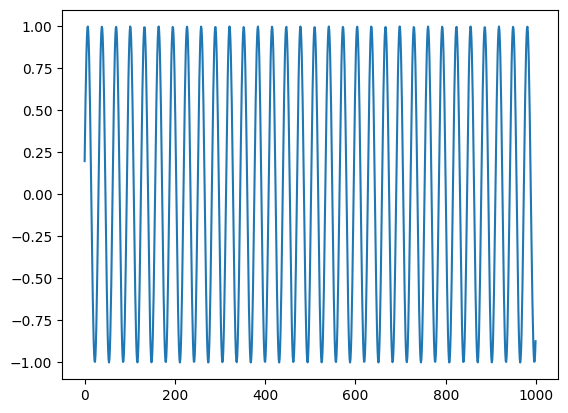

In [44]:
plt.plot(ts1)

In [96]:
import scipy.optimize
sfunc = lambda x, a, b, c : a * np.sin(b*x + c)
popt, pcov = scipy.optimize.curve_fit(sfunc, np.arange(len(ts1)), ts1, p0=[0.5, 0.0, -1.6e-07], method='trf')

In [98]:
import numpy as np
import warnings
from PeripheryFunctions.BF_iszscored import BF_iszscored


def EX_MovingThreshold(y, a = 1, b = 0.1):
    """
    Moving threshold model for extreme events in a time series.

    Inspired by an idea contained in:
    "Reactions to extreme events: Moving threshold model"
    Altmann et al., Physica A 364, 435--444 (2006)

    This algorithm is based on this idea: it uses the occurrence of extreme events
    to modify a hypothetical 'barrier' that classes new points as 'extreme' or not.
    The barrier begins at sigma, and if the absolute value of the next data point
    is greater than the barrier, the barrier is increased by a proportion 'a',
    otherwise the position of the barrier is decreased by a proportion 'b'.

    Parameters:
    y (array-like): The input (z-scored) time series
    a (float): The barrier jump parameter (in extreme event)
    b (float): The barrier decay proportion (in absence of extreme event)

    Returns:
    dict: A dictionary containing various statistics about the barrier and kicks
    """

    # Check that the time series is z-scored (just a warning)
    if not BF_iszscored(y):
        warnings.warn("The input time series should be z-scored!")
    
    if b < 0 or b > 1:
        raise ValueError('The decay proportion, b, should be between 0 and 1')
    
    N = len(y)
    y = np.abs(y)  # extreme events defined in terms of absolute deviation from mean
    q = np.zeros(N) # the barrier
    kicks = np.zeros(N)

    # Treat the barrier as knowing nothing about the time series, until it encounters it
    # (except for the std! -- starts at 1)

    # Initial condition of barrier q:
    # The barrier will get smarter about the distribution but will decay to simulate 'forgetfulness' in the original model(!)

    q[0] = 1  # begin at sigma

    for i in range(1, N):
        if y[i] > q[i-1]:  # Extreme event -- time series value more extreme than the barrier
            q[i] = (1 + a) * y[i]  # increase barrier above the new observation by a factor a
            kicks[i] = q[i] - q[i-1]  # The size of the increase
        else:
            q[i] = (1 - b) * q[i-1]  # Decrease barrier by proportion b

    # Basic statistics on the barrier dynamics, q
    out = {
        'meanq': np.mean(q),
        'medianq': np.median(q),
        'iqrq': np.percentile(q, 75, method='hazen') - np.percentile(q, 25, method='hazen'),
        'maxq': np.max(q),
        'minq': np.min(q),
        'stdq': np.std(q, ddof=1),
        'meanqover': np.mean(q - y),
        'pkick': np.sum(kicks) / (N - 1),  # probability of a kick
    }

    # Kicks (when the barrier is changed due to extreme event)
    fkicks = np.argwhere(kicks > 0).flatten()
    Ikicks = np.diff(fkicks)
    out['stdkicks'] = np.std(Ikicks, ddof=1)
    out['meankickf'] = np.mean(Ikicks)
    out['mediankicksf'] = np.median(Ikicks)
    

    return out


In [103]:
from PeripheryFunctions.BF_zscore import BF_zscore

In [105]:
import numpy as np

def MD_pNN(x):
    """
    """

    diffx = np.diff(x)
    N = len(x)

    # Calculate pNNx percentage

    Dx = np.abs(diffx) * 1000 # assume milliseconds as for RR intervals
    pnns = np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

    out = {} # dict used for output in place of MATLAB struct

    for x in pnns:
        out["pnn" + str(x) ] = sum(Dx > x) / (N-1)

    return out


In [162]:
def SC_FluctAnal(x, q = 2, wtf = 'rsrange', tauStep = 1, k = 1, lag = None, logInc = True):
    """
    """

    N = len(x)

    # Compute integrated sequence
    if lag is None or lag == 1:
        y = np.cumsum(x)
    else:
        y = np.cumsum(x[::lag])
    
    # Perform scaling over a range of tau, up to a fifth the time-series length
    if logInc:
        taur = np.unique(np.ceil(np.exp(np.linspace(np.log(5), np.log(int(np.floor(N/2))), tauStep+1))))
        taur = taur[1:]
    else:
        taur = np.arange(5, int(np.floor(N/2)) + 1, tauStep)
    ntau = len(taur)

    return taur

In [165]:
taur = SC_FluctAnal(ts1, tauStep=10)
taur

array([  8.,  13.,  20.,  32.,  50.,  80., 126., 200., 316., 500.])

In [171]:
import numpy as np

def MD_polvar(x, d = 1, D = 6):
    """
    The POLVARd measure of a time series.
    """

    dx = np.abs(np.diff(x)) # abs diff in consecutive values of the time series
    N = len(dx) # number of diffs in the input time series

    # binary representation of time series based on consecutive changes being greater than d/1000...
    xsym = dx >= d # consec. diffs exceed some threshold, d
    zseq = np.zeros(D)
    oseq = np.ones(D)

    # search for D consecutive zeros/ones
    i = 1
    pc = 0

    # seqcnt = 0
    while i <= (N-D):
        xseq = xsym[i:(i+D)]
        if (np.sum(xseq == zseq) == D) or (np.sum(xseq == oseq) == D):
            pc += 1
            i += D
        else:
            i += 1
    
    p = pc / N

    return p 


In [174]:
MD_polvar(ts3)

0.022022022022022022

In [179]:
N = len(ts1)
hist, edges = np.histogram(ts1, 10)


array([207,  90,  72,  65,  63,  64,  68,  76,  90, 205])

In [192]:
np.sqrt(N)

31.622776601683793

In [196]:
int(np.ceil(np.sqrt(N)))

32

In [195]:
hist_counts_sqrt, _ = np.histogram(ts1, bins=int(np.ceil(np.sqrt(N))))
N/np.max(hist_counts_sqrt)

8.695652173913043

In [202]:
len(np.histogram_bin_edges(ts1, bins='sqrt'))

33

In [216]:
import numpy as np

def MD_rawHRVmeas(x):

    N = len(x)
    out = {}

    # triangular histogram index
    hist_counts10, _ = np.histogram(x, 10)
    out['tri10'] = N/np.max(hist_counts10)
    hist_counts20, _ = np.histogram(x, 20)
    out['tri20'] = N/np.max(hist_counts20)
    hist_counts_sqrt, _ = np.histogram(x, bins=int(np.ceil(np.sqrt(N))))
    out['trisqrt'] = N/np.max(hist_counts_sqrt)

    # Poincare plot measures
    diffx = np.diff(x)
    out['SD1'] = 1/np.sqrt(2) * np.std(diffx, ddof=1) * 1000
    out['SD2'] = np.sqrt(2 * np.var(x, ddof=1) - (1/2) * np.std(diffx, ddof=1)**2) * 1000

    return out


In [218]:
MD_rawHRVmeas(ts1)

{'tri10': 4.830917874396135,
 'tri20': 6.896551724137931,
 'trisqrt': 8.695652173913043,
 'SD1': 99.72437694213063,
 'SD2': 996.951312902879}

In [219]:
import numpy as np
from PeripheryFunctions.BF_MakeBuffer import BF_MakeBuffer
from Operations.CO_FirstCrossing import CO_FirstCrossing

def BF_PreProcess(y, preProcessHow = None):

    if preProcessHow is not None:
        if preProcessHow == 'diff1':
            y = np.diff(y)
        elif preProcessHow == 'rescale_tau':
            tau = CO_FirstCrossing(y, 'ac', 0, 'discrete')
            y_buffer = BF_MakeBuffer(y, tau)
            y = np.mean(y_buffer, 1)
        else:
            raise ValueError(f"Unknown preprocessing setting: {preProcessHow}")    
    return y


In [224]:
from pyentrp import entropy as ent

In [240]:
ent.sample_entropy(ts1, 4, 0.4)

array([1.13297372, 0.18740919, 0.23045563, 0.16192659])

In [248]:
from pyentrp import entropy as ent
import numpy as np
from PeripheryFunctions.BF_PreProcess import BF_PreProcess


def EN_SampEN(y, M = 2, r = None, preProcessHow = None):
    """
    Parameters:
    -----------
    y :
        the input time series
    M : 
        the embedding dimension
    r : 
        the threshold
    preProcessHow:
      (i) 'diff1', incremental differencing (as per 'Control Entropy').
    """

    if r is None:
        r = 0.1 * np.std(y, ddof=1)
    if preProcessHow is not None:
        y = BF_PreProcess(y, preProcessHow)
    
    out = {}
    sampEn = ent.sample_entropy(y, M+1, r)
    # compute outputs 
    for i in range(len(sampEn)):
        out[f"sampen{i}"] = sampEn[i]
        # Quadratic sample entropy (QSE), Lake (2006):
        # (allows better comparison across r values)
        out[f"quadSampEn{i}"] = sampEn[i] + np.log(2*r)
    
    if M > 1:
        out['meanchsampen'] = np.mean(np.diff(sampEn))

    return out


In [249]:
EN_SampEN(ts1, 3, 0.4)

{'sampen0': 1.1329737161854208,
 'quadSampEn0': 0.909830164871211,
 'sampen1': 0.18740919282421611,
 'quadSampEn1': -0.035734358489993595,
 'sampen2': 0.23045563071148165,
 'quadSampEn2': 0.007312079397271937,
 'sampen3': 0.16192658822527484,
 'quadSampEn3': -0.06121696308893487,
 'meanchsampen': -0.32368237598671534}

In [256]:
from Operations.EN_SampEn import EN_SampEn
from PeripheryFunctions.BF_PreProcess import BF_PreProcess
from PeripheryFunctions.BF_zscore import BF_zscore
from PeripheryFunctions.BF_MakeBuffer import BF_MakeBuffer
import numpy as np 

def EN_mse(y, scaleRange=np.arange(1, 11), m = 2, r = 0.15, preProcessHow = None):
    """
    """
    minTsLength = 20
    numScales = len(scaleRange)

    if preProcessHow is None:
        y = BF_zscore(BF_PreProcess(y, preProcessHow))
    
    # Coarse-graining across scales
    y_cg = []
    for i in range(numScales):
        buffer_size = scaleRange[i]
        y_buffer = BF_MakeBuffer(y, buffer_size)
        y_cg.append(np.mean(y_buffer, axis=1))
    
    # Run sample entropy for each m and r value at each scale
    samp_ens = np.zeros(numScales)
    for si in range(numScales):
        if len(y_cg[si]) >= minTsLength:
            samp_en_struct = EN_SampEn(y_cg[si], m, r)
            samp_ens[si] = samp_en_struct[f'sampen{m}']
        else:
            samp_ens[si] = np.nan

    # Outputs: multiscale entropy
    if np.all(np.isnan(samp_ens)):
        if preProcessHow:
            pp_text = f"after {preProcessHow} pre-processing"
        else:
            pp_text = ""
        print(f"Warning: Not enough samples ({len(y)} {pp_text}) to compute SampEn at multiple scales")
        return {'out': np.nan}

    # Output raw values
    out = {f'sampen_s{scaleRange[i]}': samp_ens[i] for i in range(numScales)}

     # Summary statistics of the variation
    max_samp_en = np.nanmax(samp_ens)
    max_ind = np.nanargmax(samp_ens)
    min_samp_en = np.nanmin(samp_ens)
    min_ind = np.nanargmin(samp_ens)

    out.update({
        'maxSampEn': max_samp_en,
        'maxScale': scaleRange[max_ind],
        'minSampEn': min_samp_en,
        'minScale': scaleRange[min_ind],
        'meanSampEn': np.nanmean(samp_ens),
        'stdSampEn': np.nanstd(samp_ens,ddof=1),
        'cvSampEn': np.nanstd(samp_ens, ddof=1) / np.nanmean(samp_ens),
        'meanch': np.nanmean(np.diff(samp_ens))
    })

    return out


In [260]:
import numpy as np
import warnings
#import numba

#@numba.jit(nopython=True,parallel=True)
def EN_SampEn2(x,m=2,r=.2,scale=True):
    warnings.filterwarnings('ignore')

    if scale:

        r = np.std(x,ddof = 1) * r

    print(r)

    templates = make_templates(x,m)
    #print(templates)
    A = 0
    B = 0

    for i in range(templates.shape[0]):

        template = templates[i,:]

        A = A + np.sum(np.amax(np.absolute(templates-template), axis=1) < r) -1

        B = B + np.sum(np.amax(np.absolute(templates[:,0:m]-template[0:m]),axis=1) < r) - 1

    if B == 0:

        return {'Sample Entropy':np.nan,"Quadratic Entropy":np.nan}


    return {'Sample Entropy':- np.log(A/B),"Quadratic Entropy": - np.log(A/B) + np.log(2*r)}

#@numba.jit(nopython=True,parallel=True)
def make_templates(x,m):

    N = int(len(x) - (m))

    templates = np.zeros((N,m+1))

    for i in range(N):

        templates[i,:] = x[i:i+m+1]

    return templates




# def SampEn(U, m = 2, r = .2):
#
#     r = r * np.log(U)
#
#     def _maxdist(x_i, x_j):
#
#         result = max([abs(ua - va) for ua, va in zip(x_i, x_j)])
#
#         return result
#
#
#     def _phi(m):
#
#         x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
#
#         C = 0
#
#         for i in range(len(x)):
#
#             for j in range(len(x)):
#
#                 if i == j:
#
#                     continue
#
#                 C += (_maxdist(x[i], x[j]) <= r)
#
#         return C
#
#
#     N = len(U)
#
#     return -np.log(_phi(m+1) / _phi(m))

# def EN_SampEn(y,M = 2,r = 0,pre = ''):
#     if r == 0:
#         r = .1*np.std(y)
#     else:
#         r = r*np.std(y)
#     M = M + 1
#     N = len(y)
#     print('hi')
#     lastrun = np.zeros(N)
#     run = np.zeros(N)
#     A = np.zeros(M)
#     B = np.zeros(M)
#     p = np.zeros(M)
#     e = np.zeros(M)
#
#     for i in range(1,N):
#         y1 = y[i-1]
#
#         for jj in range(1,N-i + 1):
#
#             j = i + jj - 1
#
#             if np.absolute(y[j] - y1) < r:
#
#                 run[jj] = lastrun[jj] + 1
#                 M1 = min(M,run[jj])
#                 for m in range(int(M1)):
#                     A[m] = A[m] + 1
#                     if j < N:
#                         B[m] = B[m] + 1
#             else:
#                 run[jj] = 0
#         for j in range(N-1):
#             lastrun[j] = run[j]
#
#     NN = N * (N - 1) / 2
#     p[0] = A[0] / NN
#     e[0] = - np.log(p[0])
#     for m in range(1,int(M)):
#         p[m] = A[m] / B[m-1]
#         e[m] = -np.log(p[m])
#     i = 0
#     # out = {'sampen':np.zeros(len(e)),'quadSampEn':np.zeros(len(e))}
#     # for ent in e:
#     #     quaden1 = ent + np.log(2*r)
#     #     out['sampen'][i] = ent
#     #     out['quadSampEn'][i] = quaden1
#     #     i = i + 1
#     out = {'Sample Entropy':e[1],'Quadratic Entropy':e[1] + np.log(2*r)}
#     return out

In [285]:
import numpy as np
from Operations.CO_AutoCorr import CO_AutoCorr
from Operations.CO_FirstCrossing import CO_FirstCrossing

def PH_ForcePotential(y, whatPotential = 'dblwell', params = None):
    """
    Couples the values of the time series to a dynamical system.

    The input time series forces a particle in the given potential well.

    Args:
    y (array-like): The input time series.
    what_potential (str): The potential function to simulate:
                          'dblwell' (a double well potential function) or
                          'sine' (a sinusoidal potential function).
    params (list): The parameters for simulation, should be in the form:
                   [alpha, kappa, deltat]

    Returns:
    dict: Statistics summarizing the trajectory of the simulated particle.
    """
    if params is None:
        if whatPotential == 'dblwell':
            params = [2, 0.1, 0.1]
        elif whatPotential == 'sine':
            params = [1, 1, 1]
        else:
            ValueError(f"Unknown system {whatPotential}")
    else:
        # check params
        if not isinstance(params, list):
            raise ValueError("Expected list of parameters.")
        else:
            if len(params) != 3:
                raise ValueError("Expected 3 parameters.")
    
    N = len(y) # length of the time series

    alpha, kappa, deltat = params

    # specify potential function
    if whatPotential == 'sine':
        V = lambda x : -np.cos(x/alpha)
        F = lambda x : np.sin(x/alpha)/alpha
    elif whatPotential == 'dblwell':
        F = lambda x : -x**3 + alpha**2 * x
        V = lambda x : x**4 / 4 - alpha**2 * x**2 / 2
    else:
        raise ValueError(f"Unknown potential function {whatPotential}")
    
    x = np.zeros(N) # position
    v = np.zeros(N) # velocity

    for i in range(1, N):
        x[i] = x[i-1] + v[i-1]*deltat + (F(x[i-1]) + y[i-1] - kappa*v[i-1])*deltat**2
        v[i] = v[i-1] + (F(x[i-1]) + y[i-1] - kappa*v[i-1])*deltat

    # check the trajectory didn't blow out
    if np.isnan(x[-1]) or np.abs(x[-1]) > 1E10:
        return np.NaN
    
    # Output some basic features of the trajectory
    out = {}
    out['mean'] = np.mean(x) # mean position
    out['median'] = np.median(x) # median position
    out['std'] = np.std(x, ddof=1) # std. dev.
    out['range'] = np.ptp(x)
    out['proppos'] = np.sum(x > 0)/N
    out['pcross'] = np.sum(x[:-1] * x[1:] < 0) / (N - 1)
    out['ac1'] = np.abs(CO_AutoCorr(x, 1, 'Fourier')[0])
    out['ac10'] = np.abs(CO_AutoCorr(x, 10, 'Fourier')[0])
    out['ac50'] = np.abs(CO_AutoCorr(x, 50, 'Fourier')[0])
    out['tau'] = CO_FirstCrossing(x, 'ac', 0, 'continuous')
    out['finaldev'] = np.abs(x[-1]) # final position

    # additional outputs for dbl well
    if whatPotential == 'dblwell':
        out['pcrossup'] = np.sum((x[:-1] - alpha) * (x[1:] - alpha) < 0) / (N - 1)
        out['pcrossdown'] = np.sum((x[:-1] + alpha) * (x[1:] + alpha) < 0) / (N - 1)

    return out


In [286]:
PH_ForcePotential(ts1, 'sine')

{'mean': 3.134421323722765,
 'median': 3.1379719607268908,
 'std': 0.8738893219198849,
 'range': 4.415693591342526,
 'proppos': 0.999,
 'pcross': 0.0,
 'ac1': 0.9694821772518506,
 'ac10': 0.40580882450000605,
 'ac50': 0.7557857723104995,
 'tau': 7.764238932851466,
 'finaldev': 1.876886533672267}

In [290]:
from pyentrp import entropy as ent
import numpy as np
from PeripheryFunctions.BF_PreProcess import BF_PreProcess

def EN_SampEn1(y, M = 2, r = None, preProcessHow = None):
    """
    Adaptation of the SampEn function in MATLAB using the pyEntropy
    toolkit as a stand-in for the original physionet toolkit.
    Gives similar results to the MATLAB implementation, but not
    exactly equivalent. 

    Parameters:
    -----------
    y (array-like):
        the input time series
    M (int, optional): 
        the embedding dimension
    r (float, optional): 
        the threshold
    preProcessHow (str, optional):
      (i) 'diff1', incremental differencing (as per 'Control Entropy').
    
    Returns:
    --------
    dict :
        A dictionary of sample entropy and quadratic sample entropy
    """

    if r is None:
        r = 0.1 * np.std(y, ddof=1)
    if preProcessHow is not None:
        y = BF_PreProcess(y, preProcessHow)
    
    out = {}
    sampEn = ent.sample_entropy(y, M+1, r)
    # compute outputs 
    for i in range(len(sampEn)):
        out[f"sampen{i}"] = sampEn[i]
        # Quadratic sample entropy (QSE), Lake (2006):
        # (allows better comparison across r values)
        out[f"quadSampEn{i}"] = sampEn[i] + np.log(2*r)
    
    if M > 1:
        out['meanchsampen'] = np.mean(np.diff(sampEn))

    return out


In [324]:
import numpy as np
import warnings
from PeripheryFunctions.BF_iszscored import BF_iszscored
from PeripheryFunctions.BF_SimpleBinner import BF_SimpleBinner

def DN_HistogramAsymmetry(y, numBins = 10, doSimple = True):
    """
    """
    if not BF_iszscored(y):
        warnings.warn("DN_HistogramAsymmetry assumes a z-scored (or standardised) input")
    
    # compute the histogram seperately from positive and negative values in the data
    yPos = y[y > 0] # filter out the positive vals
    yNeg = y[y < 0]

    if doSimple:
        countsPos, binEdgesPos = BF_SimpleBinner(yPos, numBins)
        countsNeg, binEdgesNeg = BF_SimpleBinner(yNeg, numBins)
    else:
        countsPos, binEdgesPos = np.histogram(yPos, numBins)
        countsNeg, binEdgesNeg = np.histogram(yNeg, numBins)
    
    # normalise by the total counts
    NnonZero = np.sum(y!=0)
    pPos = countsPos/NnonZero
    pNeg = countsNeg/NnonZero

    # compute bin centers from bin edges
    binCentersPos = np.mean([binEdgesPos[:-1], binEdgesPos[1:]], axis=0)
    binCentersNeg = np.mean([binEdgesNeg[:-1], binEdgesNeg[1:]], axis=0)

    # Histogram counts and overall density differences
    out = {}
    out['densityDiff'] = np.sum(y > 0) - np.sum(y < 0)  # measure of asymmetry about the mean
    out['modeProbPos'] = np.max(pPos)
    out['modeProbNeg'] = np.max(pNeg)
    out['modeDiff'] = out['modeProbPos'] - out['modeProbNeg']

    # Mean position of maximums (if multiple)
    out['posMode'] = np.mean(binCentersPos[pPos == out['modeProbPos']])
    out['negMode'] = np.mean(binCentersNeg[pNeg == out['modeProbNeg']])
    out['modeAsymmetry'] = out['posMode'] + out['negMode']

    return out
    

In [325]:
DN_HistogramAsymmetry(ts2)

{'densityDiff': -22,
 'modeProbPos': 0.094,
 'modeProbNeg': 0.096,
 'modeDiff': -0.0020000000000000018,
 'posMode': 0.6125897250000001,
 'negMode': -0.5567158999999998,
 'modeAsymmetry': 0.055873825000000266}

In [339]:
import numpy as np
from PeripheryFunctions.BF_SimpleBinner import BF_SimpleBinner

def DN_HistogramMode(y, numBins = 10, doSimple = True):
    """
    Mode of a data vector.
    Measures the mode of the data vector using histograms with a given number
    of bins.

    Parameters:
    -----------
    y : array-like
        the input data vector
    numBins : int, optional
        the number of bins to use in the histogram
    doSimple : bool, optional
        whether to use a simple binning method (linearly spaced bins)

    Returns:
    --------
    out : float
        the mode of the data vector using histograms with numBins bins. 
    """

    if isinstance(numBins, int):
        if doSimple:
            N, binEdges = BF_SimpleBinner(y, numBins)
        else:
            # this gives a different result to MATLAB for the same number of bins 
            # better to use the simple binner (as set by default)
            N, binEdges = np.histogram(y, bins=numBins)
    elif isinstance(numBins, str):
        # NOTE: auto doesn't yield the same number of bins as MATLAB's auto, despite both using the same binning algs. 
        bin_edges = np.histogram_bin_edges(y, bins=numBins)
        N, binEdges = np.histogram(y, bins=bin_edges)
    else:
        raise ValueError("Unknown format for numBins")

    # compute bin centers from bin edges
    binCenters = np.mean([binEdges[:-1], binEdges[1:]], axis=0)

    # mean position of maximums (if multiple)
    out = np.mean(binCenters[N == np.max(N)])

    return out


In [341]:
from statsmodels.tsa.arima_model import ARIMA

In [416]:
import numpy as np


def PN_sampenc(y, M = 1, r = None, justM = False):
    """
    """
    if r is None:
        r = 0.1 * np.std(y, ddof=1)
    
    N = len(y)
    lastrun = np.zeros(N)
    run = np.zeros(N)
    A = np.zeros(M)
    B = np.zeros(M)
    p = np.zeros(M)
    e = np.zeros(M)

    # get counting 
    for i in range(N-1): # go through each point in the time series, counting matches
        y1 = y[i]
        for jj in range(N-i-1):
            # compare to future index, j
            j = i + jj + 1
            # this future point, j, matches the time series value at i
            if np.abs(y[j]-y1) < r:
                run[jj] = lastrun[jj] + 1 # increase run count for this lag
                M1 = int(min(M, run[jj]))
                for m in range(M1):
                    A[m] += 1
                    if j < N - 1:
                        B[m] += 1
            else:
                run[jj] = 0
        for j in range(N-i-1):
            lastrun[j] = run[j]
        
    # Calculate for m = 1
    NN = N*(N-1)/2
    p[0] = A[0]/NN
    e[0] = -np.log(p[0])

    # calculate for m > 1, up to M
    for m in range(1, M):
        p[m] = A[m]/B[m-1]
        e[m] = -np.log(p[m])

    # Flag to output the entropy and probability just at the maximum requested m
    if justM:
        e = e[-1]
        p = p[-1]
    
    return e, p, A, B


In [423]:
e, p, A, B = PN_sampenc(ts3)

In [440]:
import numpy as np
from PeripheryFunctions.BF_PreProcess import BF_PreProcess

def EN_SampEn(y, M = 2, r = None, preProcessHow = None):
    """
   

    Parameters:
    -----------
    y (array-like):
        the input time series
    M (int, optional): 
        the embedding dimension
    r (float, optional): 
        the threshold
    preProcessHow (str, optional):
      (i) 'diff1', incremental differencing (as per 'Control Entropy').
    
    Returns:
    --------
    dict :
        A dictionary of sample entropy and quadratic sample entropy
    """

    if r is None:
        r = 0.1 * np.std(y, ddof=1)
    if preProcessHow is not None:
        y = BF_PreProcess(y, preProcessHow)
    
    out = {}
    sampEn, _, _, _ = PN_sampenc(y, M+1)
    # compute outputs 
    for i in range(len(sampEn)):
        out[f"sampen{i}"] = sampEn[i]
        # Quadratic sample entropy (QSE), Lake (2006):
        # (allows better comparison across r values)
        out[f"quadSampEn{i}"] = sampEn[i] + np.log(2*r)
    
    if M > 1:
        out['meanchsampen'] = np.mean(np.diff(sampEn))

    return out


In [468]:
import numpy as np

def SY_DriftingMean(y, segmentHow = 'num', l = None):
    """
    """
    N = len(y)
    
    if l is None:
        if segmentHow == 'num':
            l = 5 # 5 segments
        elif segmentHow == 'fix':
            l = 200 # 200 sample segments

    if segmentHow == 'num':
        l = int(np.floor(N/l))
    elif segmentHow != 'fix':
        raise ValueError(f"Unknown input setting {segmentHow}")
    
    # Check for short time series
    if l == 0 or N < l: # doesn't make sense to split into more windows than there are data points
        return np.NaN
    
    # get going
    numFits = int(np.floor(N/l)) # number of times l fits completely into N
    z = np.zeros((l, numFits))
    for i in range(numFits):
        z[:, i] = y[i*l : (i+1)*l]
    zm = np.mean(z, axis=0)
    zv = np.var(z, ddof=1, axis=0)
    meanVar = np.mean(zv)
    maxMean = np.max(zm)
    minMean = np.min(zm)
    meanMean = np.mean(zm)

    # Output stats
    out = {}
    out['max'] = maxMean/meanVar
    out['min'] = minMean/meanVar
    out['mean'] = meanMean/meanVar
    out['meanmaxmin'] = (out['max'] + out['min'])/2
    out['meanabsmaxmin'] = (np.abs(out['max']) + np.abs(out['min']))/2

    return out


In [475]:
SY_DriftingMean(ts3, 'num', 10)

{'max': 0.1812232844588266,
 'min': -0.08081626740114163,
 'mean': 0.03773606897898456,
 'meanmaxmin': 0.050203508528842485,
 'meanabsmaxmin': 0.13101977592998412}

In [484]:
from Operations.DN_HistogramAsymmetry import DN_HistogramAsymmetry
from scipy.signal import detrend

In [497]:
def SY_Trend(y):
    """
    """
    if not BF_iszscored(y):
        warnings.warn('The input time series should be z-scored')
    
    N = len(y)

    # ratio of std before and after linear detrending
    out = {}
    dt_y = detrend(y)
    out['stdRatio'] = np.std(dt_y, ddof=1) / np.std(y, ddof=1)
    
    # do a linear fit
    # need to use the same xrange as MATLAB with 1 indexing for correct result
    coeffs = np.polyfit(range(1, N+1), y, 1)
    out['gradient'] = coeffs[0]
    out['intercept'] = coeffs[1]

    # Stats on the cumulative sum
    yC = np.cumsum(y)
    out['meanYC'] = np.mean(yC)
    out['stdYC'] = np.std(yC, ddof=1)
    coeffs_yC = np.polyfit(range(1, N+1), yC, 1)
    out['gradientYC'] = coeffs_yC[0]
    out['interceptYC'] = coeffs_yC[1]

    # Mean cumsum in first and second half of the time series
    out['meanYC12'] = np.mean(yC[:int(np.floor(N/2))])
    out['meanYC22'] = np.mean(yC[int(np.floor(N/2)):])

    return out

In [500]:
SY_Trend(ts3)

{'stdRatio': 0.9999379627593226,
 'gradient': -3.877747378885397e-05,
 'intercept': 0.0576837447413214,
 'meanYC': 22.388400282169982,
 'stdYC': 10.415701432666614,
 'gradientYC': 0.02681196715359477,
 'interceptYC': 8.969010721795804,
 'meanYC12': 15.942034066939996,
 'meanYC22': 28.83476649739997}

In [494]:
coeffs = np.polyfit(range(1, len(ts1)+1), ts1, 1)
coeffs[1]

0.025823918703303333

In [506]:
ts5 = np.random.randn(2)

In [508]:
out = np.diff(ts5, 2)

In [509]:
len(out)

0

In [10]:
from Operations.SY_StdNthDer import SY_StdNthDer

In [516]:
ms = np.array([SY_StdNthDer(ts1, i) for i in range(1, 11)])

In [22]:
from scipy.optimize import curve_fit

In [87]:
from Operations.SY_StatAv import SY_StatAv as stav

In [91]:
import numpy as np

def SY_StatAv3(y, what_type='seg', n=5):
    """
    Simple mean-stationarity metric, StatAv.

    The StatAv measure divides the time series into non-overlapping subsegments,
    calculates the mean in each of these segments and returns the standard deviation
    of this set of means.

    Empirically mean-stationary data would display StatAv approaching to zero.

    Args:
    y (array-like): The input time series
    what_type (str): The type of StatAv to perform:
        'seg': divide the time series into n segments
        'len': divide the time series into segments of length n
    n (int): Either the number of subsegments ('seg') or their length ('len')

    Returns:
    out: float 
        The StatAv statistic
    """
    N = len(y)

    if what_type == 'seg':
        # divide time series into n segments
        p = N // n  # integer division, lose the last N mod n data points
        M = np.array([np.mean(y[p*j:p*(j+1)]) for j in range(n)])
    elif what_type == 'len':
        if N > 2*n:
            pn = N // n
            M = np.array([np.mean(y[j*n:(j+1)*n]) for j in range(pn)])
        else:
            print(f"This time series (N = {N}) is too short for StatAv({what_type},'{n}')")
            return np.nan
    else:
        raise ValueError(f"Error evaluating StatAv of type '{what_type}', please select either 'seg' or 'len'")

    s = np.std(y)  # should be 1 (for a z-scored time-series input)
    sdav = np.std(M)
    return sdav / s


In [94]:
SY_StatAv3(ts3, 'seg', 30)

0.18558394763043523

In [98]:
rng = np.random.RandomState(0)

In [100]:
rng.randint(400)

172

In [13]:
import numpy as np
from Operations.CO_FirstCrossing import CO_FirstCrossing
from Operations.EN_SampEn import EN_SampEn
from Operations.CO_AutoCorr import CO_AutoCorr
import warnings
from scipy import stats

def SY_SpreadRandomLocal(y, l = 100, numSegs = 100, randomSeed = None):
    """
    """
    if isinstance(l, str):
        taug = CO_FirstCrossing(y, 'ac', 0, 'discrete')
        if l == 'ac2':
            l = 2 * taug
        elif l == 'ac5':
            l = 5 * taug
        else:
            raise ValueError(f"Unknown specifier '{l}'")
        
        # Very short l for this sort of time series:
        if l < 5:
            print(f"Warning: This time series has a very short correlation length; "
                  f"Setting l={l} means that changes estimates will be difficult to compare...")

    N = len(y)
    if l > 0.9 * N: # operation is not suitable -- time series is too short
        warnings.warn(f"This time series (N = {N}) is too short to use l = {l}")
        return np.NaN
    
    # numSegs segments, each of length segl data points
    numFeat = 8
    qs = np.zeros((numSegs, numFeat))
    # set the random seed for reproducibility
    np.random.seed(randomSeed)

    for j in range(numSegs):
        ist = np.random.randint(N - l)
        ifh = ist + l
        ySub = y[ist:ifh]

        qs[j, 0] = np.mean(ySub)
        qs[j, 1] = np.std(ySub, ddof=1)
        qs[j, 2] = stats.skew(ySub)
        qs[j, 3] = stats.kurtosis(ySub)
        entropyOut = EN_SampEn(ySub, 1, 0.15)
        qs[j, 4] = entropyOut['quadSampEn1']
        qs[j, 5] = CO_AutoCorr(ySub, 1, 'Fourier')[0]
        qs[j, 6] = CO_AutoCorr(ySub, 2, 'Fourier')[0]
        qs[j, 7] = CO_FirstCrossing(ySub, 'ac', 0, 'continuous') # first zero crossing
    
    fs = np.zeros((numFeat, 2))
    fs[:, 0] = np.nanmean(qs, axis=0)
    fs[:, 1] = np.nanstd(qs, axis=0, ddof=1)

    out = {
        'meanmean': fs[0, 0], 'meanstd': fs[1, 0], 'meanskew': fs[2, 0], 'meankurt': fs[3, 0],
        'meansampen1_015': fs[4, 0], 'meanac1': fs[5, 0], 'meanac2': fs[6, 0], 'meantaul': fs[7, 0],
        'stdmean': fs[0, 1], 'stdstd': fs[1, 1], 'stdskew': fs[2, 1], 'stdkurt': fs[3, 1],
        'stdsampen1_015': fs[4, 1], 'stdac1': fs[5, 1], 'stdac2': fs[6, 1], 'stdtaul': fs[7, 1]
    }

    return out


In [5]:
from Operations.SY_SpreadRandomLocal import SY_SpreadRandomLocal as srl

In [9]:

cums = [range(0, i) for i in range(N)]

In [15]:
cums = np.zeros(len(ts1))
for i in range(len(ts1)):
    cums[i] = np.ptp(ts1[:i+1])  # np.ptp calculates the range (peak to peak)


In [35]:
import numpy as np

def SY_RangeEvolve(y):
    """
    """
    N = len(y)
    out = {} # initialise storage
    cums = np.zeros(N)
    for i in range(N):
        cums[i] = np.ptp(y[:i+1])  # np.ptp calculates the range (peak to peak)
    
    fullr = np.ptp(y)

    # return number of unqiue entries in a vector, x
    lunique = lambda x : len(np.unique(x))
    out['totnuq'] = lunique(cums)

    # how many of the unique extrema are in the first <proportions> of time series? 
    cumtox = lambda x : lunique(cums[:int(np.floor(N*x))])/out['totnuq']
    out['nuqp1'] = cumtox(0.01)
    out['nuqp10'] = cumtox(0.1)
    out['nuqp20'] = cumtox(0.2)
    out['nuqp50'] = cumtox(0.5)

    # how many unique extrema are in the first <length> of time series? 
    Ns = [10, 50, 100, 1000]
    for Nval in Ns:
        if N >= Nval:
            out[f'nuql{Nval}'] = lunique(cums[:Nval])/out['totnuq']
        else:
            out[f'nuql{N}'] = np.NaN
    
    # (**2**) Actual proportion of full range captured at different points
    out['p1'] = cums[int(np.ceil(N*0.01))]/fullr
    out['p10'] = cums[int(np.ceil(N*0.1))]/fullr
    out['p20'] = cums[int(np.ceil(N*0.2))]/fullr
    out['p50'] = cums[int(np.ceil(N*0.5))]/fullr

    for Nval in Ns:
        if N >= Nval:
            out[f'l{Nval}'] = cums[Nval-1]/fullr
        else:
            out[f'l{Nval}'] = np.NaN
    
    
    return out

In [40]:
from Operations.SY_RangeEvolve import SY_RangeEvolve as re

In [75]:
import numpy as np
from PeripheryFunctions.BF_iszscored import BF_iszscored
from Operations.CO_AutoCorr import CO_AutoCorr
from PeripheryFunctions.PN_sampenc import PN_sampenc
from warnings import warn
from scipy.stats import iqr, skew, kurtosis

def SY_LocalGlobal(y, subsetHow = 'l', n = None, randomSeed = 0):
    """
    """

    # check input time series is z-scored
    if not BF_iszscored(y):
        warn(f"The input time series should be z-scored")
    
    if n is None:
        if subsetHow in ['l', 'unicg', 'randcg']:
            n = 100 # 100 samples
        elif subsetHow == 'p':
            n = 0.1 # 10 % of time series
    
    N = len(y)

    # Determine subset range to use: r
    if subsetHow == 'l':
        # take first n pts of time series
        r = np.arange(min(n, N))
    elif subsetHow == 'p':
        # take initial proportion n of time series
        r = np.arange(int(np.ceil(N*n)))
    elif subsetHow == 'unicg':
        r = int(np.ceil(np.linspace(0, N-1, n)))
    elif subsetHow == 'randcg':
        np.random.seed(randomSeed) # set seed for reproducibility
        # Take n random points in time series; there could be repeats
        r = np.random.randint(0, N, n)
    else:
        raise ValueError(f"Unknown specifier, {subsetHow}")

    if len(r) < 5:
        # It's not really appropriate to compute statistics on less than 5 datapoints
        warn(f"Time series (of length {N}) is too short")
        return np.NaN
    
    # Compare statistics of this subset to those obtained from the full time series
    out = {}
    out['absmean'] = np.abs(np.mean(y[r])) # Makes sense without normalization if y is z-scored
    out['std'] = np.std(y[r], ddof=1) # Makes sense without normalization if y is z-scored
    out['median'] = np.median(y[r]) # if median is very small then normalization could be very noisy
    raw_iqr_yr = np.percentile(y[r], 75, method='hazen') - np.percentile(y[r], 25, method='hazen')
    raw_iqr_y = np.percentile(y, 75, method='hazen') - np.percentile(y, 25, method='hazen')
    out['iqr'] = np.abs(1 - (raw_iqr_yr/raw_iqr_y))
    out['skewness'] = np.abs(1 - (skew(y[r])/skew(y)))
    # use Pearson definition (normal ==> 3.0)
    out['kurtosis'] = np.abs(1 - (kurtosis(y[r], fisher=False)/kurtosis(y, fisher=False)))
    out['ac1'] = np.abs(1 - (CO_AutoCorr(y[r], 1, 'Fourier')[0]/CO_AutoCorr(y, 1, 'Fourier')[0]))
    out['sampen101'] = PN_sampenc(y[r], 1, 0.1, True)[0]/PN_sampenc(y, 1, 0.1, True)[0]


    return out


In [77]:
from Operations.SY_LocalGlobal import SY_LocalGlobal as sylg

In [4]:
from Operations.SY_LocalGlobal import SY_LocalGlobal10 as sylg10

In [132]:
import numpy as np
from PeripheryFunctions.BF_iszscored import BF_iszscored
from Operations.CO_AutoCorr import CO_AutoCorr
from PeripheryFunctions.PN_sampenc import PN_sampenc
from warnings import warn
from scipy.stats import iqr, skew, kurtosis

def SY_LocalGlobal10(y, subsetHow = 'l', n = None, randomSeed = 0):
    """
    Compare local statistics to global statistics of a time series.

    Parameters:
    -----------
    y : array_like
        The time series to analyze.
    subsetHow : str, optional
        The method to select the local subset of time series:
        'l': the first n points in a time series
        'p': an initial proportion of the full time series
        'unicg': n evenly-spaced points throughout the time series
        'randcg': n randomly-chosen points from the time series (chosen with replacement)
    n : int or float, optional
        The parameter for the method specified by subset_how.
    random_seed : int, optional
        Seed for random number generator (for 'randcg' option).

    Returns:
    --------
    dict
        A dictionary containing various statistical measures comparing
        the subset to the full time series.
    """
    # check input time series is z-scored
    if not BF_iszscored(y):
        warn(f"The input time series should be z-scored")
    
    if n is None:
        if subsetHow in ['l', 'unicg', 'randcg']:
            n = 100 # 100 samples
        elif subsetHow == 'p':
            n = 0.1 # 10 % of time series
    
    N = len(y)

    # Determine subset range to use: r
    if subsetHow == 'l':
        # take first n pts of time series
        r = np.arange(min(n, N))
    elif subsetHow == 'p':
        # take initial proportion n of time series
        r = np.arange(int(np.ceil(N*n)))
    elif subsetHow == 'unicg':
        r = np.round(np.linspace(1, N, n)).astype(int) - 1
    elif subsetHow == 'randcg':
        np.random.seed(randomSeed) # set seed for reproducibility
        # Take n random points in time series; there could be repeats
        r = np.random.randint(0, N, n)
    else:
        raise ValueError(f"Unknown specifier, {subsetHow}")

    if len(r) < 5:
        # It's not really appropriate to compute statistics on less than 5 datapoints
        warn(f"Time series (of length {N}) is too short")
        return np.NaN
    
    # Compare statistics of this subset to those obtained from the full time series
    out = {}
    out['absmean'] = np.abs(np.mean(y[r])) # Makes sense without normalization if y is z-scored
    out['std'] = np.std(y[r], ddof=1) # Makes sense without normalization if y is z-scored
    out['median'] = np.median(y[r]) # if median is very small then normalization could be very noisy
    raw_iqr_yr = np.percentile(y[r], 75, method='hazen') - np.percentile(y[r], 25, method='hazen')
    raw_iqr_y = np.percentile(y, 75, method='hazen') - np.percentile(y, 25, method='hazen')
    out['iqr'] = np.abs(1 - (raw_iqr_yr/raw_iqr_y))
    out['skewness'] = np.abs(1 - (skew(y[r])/skew(y)))
    # use Pearson definition (normal ==> 3.0)
    out['kurtosis'] = np.abs(1 - (kurtosis(y[r], fisher=False)/kurtosis(y, fisher=False)))
    out['ac1'] = np.abs(1 - (CO_AutoCorr(y[r], 1, 'Fourier')[0]/CO_AutoCorr(y, 1, 'Fourier')[0]))
    out['sampen101'] = PN_sampenc(y[r], 1, 0.1, True)[0]/PN_sampenc(y, 1, 0.1, True)[0]


    return out


In [3]:
from Operations.SY_KPSStest import SY_KPSStest

In [15]:
from Operations.ST_FitPolynomial import ST_FitPolynomial

In [19]:
ST_FitPolynomial(ts3, 3)

1.003963787571347